In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

sns.set_palette("colorblind")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## load data, define features, train/test split

In [3]:
binned_df = pd.read_csv('data/binned_k100_1950to2024.csv')

In [4]:
features = ['TMIN', 'TMAX', 'TAVG', 'SNOW', 'PRCP', 'HTDD']

In [5]:
test_df = binned_df[binned_df['Year'].between(2021,2024)]
train_df = binned_df[binned_df['Year'].between(1950,2020)]

## define functions for linear and quadratic models

In [6]:
def linear_reg(train_data, test_data, feature, scale=False, return_params=False):
    if scale:
        reg = Pipeline([('scale', StandardScaler()), 
                        ('reg', LinearRegression())])
    else:
        reg = LinearRegression()
    
    reg.fit(train_data[['Year']], train_data[feature])
    
    forecast = reg.predict(test_data[['Year']])
    fit = reg.predict(train_data[['Year']])
    
    rmse_forecast = root_mean_squared_error(test_data[feature], forecast)
    
    if return_params:
        return forecast, fit, rmse_forecast, reg.intercept_, reg.coef_[0]
    else:
        return forecast, fit, rmse_forecast

In [7]:
def quadratic_reg(train_data, test_data, feature, scale=False, return_params=False):
    if scale:
        reg = Pipeline([('scale', StandardScaler()), 
                        ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)), 
                        ('reg', LinearRegression())])
    else:
        reg = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)), 
                        ('reg', LinearRegression())])
    
    reg.fit(train_data[['Year']], train_data[feature])
    
    forecast = reg.predict(test_data[['Year']])
    fit = reg.predict(train_data[['Year']])
    
    rmse_forecast = root_mean_squared_error(test_data[feature], forecast)
    
    if return_params:
        return forecast, fit, rmse_forecast, reg['reg'].intercept_, reg['reg'].coef_[0], reg['reg'].coef_[1]
    return forecast, fit, rmse_forecast

In [8]:
def calc_rmses_for_cluster(cluster_id, n_horizon, horizon_length):
    cluster_df = binned_df[binned_df['Cluster_ID']==cluster_id]
    cluster_train = cluster_df[cluster_df['Year'].between(1950, 2020-((n_horizon)*horizon_length))]
    cluster_test = cluster_df[cluster_df['Year'].between(2020-((n_horizon)*horizon_length)+1, 2020-((n_horizon-1)*horizon_length))]
    
    linear_rmses_forecast = np.empty(len(features))
    quad_rmses_forecast = np.empty(len(features))
    for i, feature in enumerate(features):
        cluster_train_clean = cluster_train.dropna(subset=[feature])
        cluster_test_clean = cluster_test.dropna(subset=[feature])
        _, _, linear_rmses_forecast[i] = linear_reg(cluster_train_clean, cluster_test_clean, feature)
        _, _, quad_rmses_forecast[i] = quadratic_reg(cluster_train_clean, cluster_test_clean, feature)
        
    return linear_rmses_forecast, quad_rmses_forecast

In [9]:
def calc_rmse_all_clusters(n_horizon, horizon_length, n_clusters=100):
    cluster_linear_rmses_forecast = np.empty((len(features), n_clusters))
    cluster_quad_rmses_forecast = np.empty((len(features), n_clusters))
    
    for cluster_id in range(n_clusters):
        cluster_linear_rmses_forecast[:,cluster_id], cluster_quad_rmses_forecast[:,cluster_id] = calc_rmses_for_cluster(cluster_id, n_horizon, horizon_length)
        
    return cluster_linear_rmses_forecast, cluster_quad_rmses_forecast

## cross-validation

In [10]:
cluster_linear_rmses_forecast = np.empty((5,len(features),100))
cluster_quad_rmses_forecast = np.empty((5,len(features),100))

for n_horizon in range(1,6):
    cluster_linear_rmses_forecast[n_horizon-1], cluster_quad_rmses_forecast[n_horizon-1] = calc_rmse_all_clusters(n_horizon, horizon_length=10)

### see which model is preferred

In [11]:
for n_horizon in range(1,6):
    print(f'When forecasting {2020-((n_horizon)*10)+1} to {2020-((n_horizon-1)*10)} using 1950 to {2020-((n_horizon)*10)}:')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,0,:]>cluster_quad_rmses_forecast[n_horizon-1,0,:])}/100 clusters prefer a quadratic {features[0]} model.')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,1,:]>cluster_quad_rmses_forecast[n_horizon-1,1,:])}/100 clusters prefer a quadratic {features[1]} model.')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,2,:]>cluster_quad_rmses_forecast[n_horizon-1,2,:])}/100 clusters prefer a quadratic {features[2]} model.')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,3,:]>cluster_quad_rmses_forecast[n_horizon-1,3,:])}/100 clusters prefer a quadratic {features[3]} model.')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,4,:]>cluster_quad_rmses_forecast[n_horizon-1,4,:])}/100 clusters prefer a quadratic {features[4]} model.')
    print(f'{np.sum(cluster_linear_rmses_forecast[n_horizon-1,5,:]>cluster_quad_rmses_forecast[n_horizon-1,5,:])}/100 clusters prefer a quadratic {features[5]} model.')
    print('')

When forecasting 2011 to 2020 using 1950 to 2010:
56/100 clusters prefer a quadratic TMIN model.
47/100 clusters prefer a quadratic TMAX model.
57/100 clusters prefer a quadratic TAVG model.
25/100 clusters prefer a quadratic SNOW model.
46/100 clusters prefer a quadratic PRCP model.
30/100 clusters prefer a quadratic HTDD model.

When forecasting 2001 to 2010 using 1950 to 2000:
32/100 clusters prefer a quadratic TMIN model.
30/100 clusters prefer a quadratic TMAX model.
33/100 clusters prefer a quadratic TAVG model.
22/100 clusters prefer a quadratic SNOW model.
39/100 clusters prefer a quadratic PRCP model.
14/100 clusters prefer a quadratic HTDD model.

When forecasting 1991 to 2000 using 1950 to 1990:
53/100 clusters prefer a quadratic TMIN model.
34/100 clusters prefer a quadratic TMAX model.
40/100 clusters prefer a quadratic TAVG model.
55/100 clusters prefer a quadratic SNOW model.
18/100 clusters prefer a quadratic PRCP model.
60/100 clusters prefer a quadratic HTDD model.

W

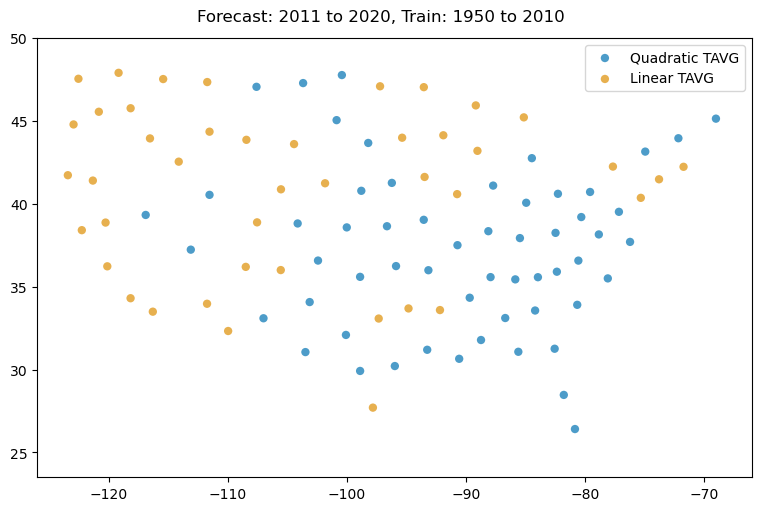

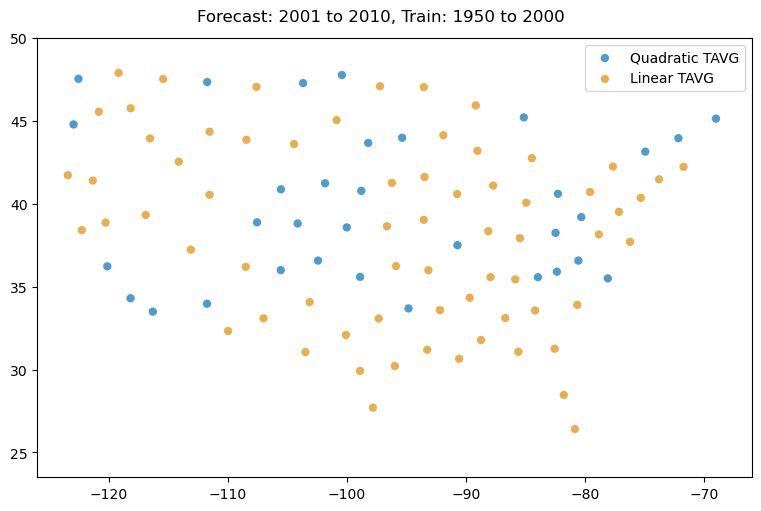

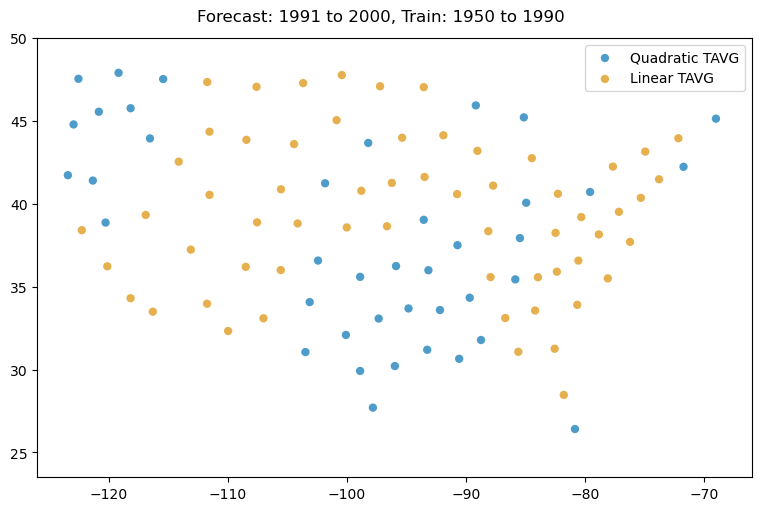

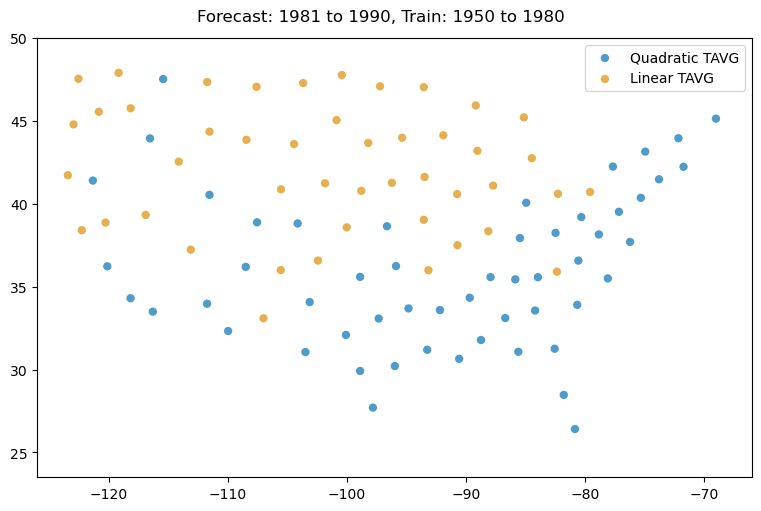

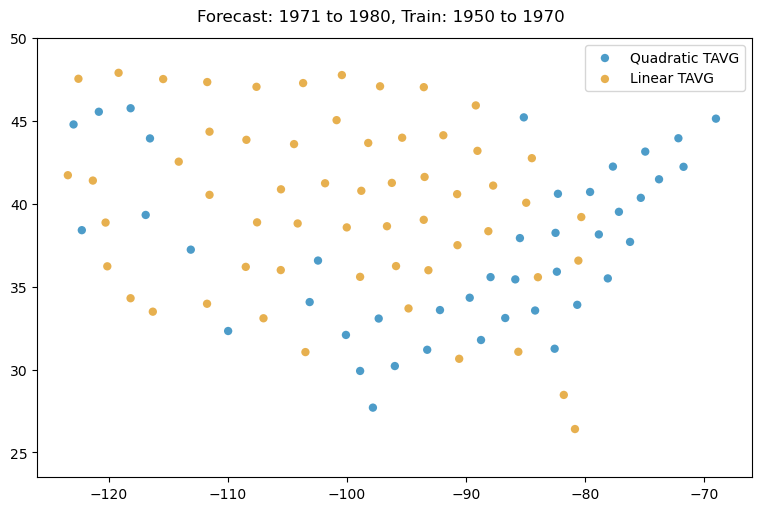

In [12]:
for n_horizon in range(1,6):
    quad_tavg = cluster_linear_rmses_forecast[n_horizon-1,2,:]>cluster_quad_rmses_forecast[n_horizon-1,2,:]
    year_to_plot = 2020-((n_horizon)*10)+5 # this doesn't actually matter because cluster centroid coordinates are fixed
    binned_df_in_year = binned_df[binned_df['Year']==year_to_plot]
    fig, ax = plt.subplots(figsize=(7.5,5), constrained_layout=True)
    ax.scatter(binned_df_in_year['Lon'][quad_tavg].values, binned_df_in_year['Lat'][quad_tavg].values, alpha=0.7, marker='o', edgecolor='none', label='Quadratic TAVG')
    ax.scatter(binned_df_in_year['Lon'][~quad_tavg].values, binned_df_in_year['Lat'][~quad_tavg].values, alpha=0.7, marker='o', edgecolor='none', label='Linear TAVG')
    ax.set_xlim(-126,-66)
    ax.set_ylim(23.5,50)
    ax.legend()
    fig.suptitle(f'Forecast: {2020-((n_horizon)*10)+1} to {2020-((n_horizon-1)*10)}, Train: 1950 to {2020-((n_horizon)*10)}')

From the above results, it looks like neither model is particularly preferred, and in fact the preferred model can change for a given cluster across the different cross-validation sets.

### plot fits and forecasts for final cross-validation set

In [17]:
n_horizon = 1
horizon_length = 10
for cluster_id in range(100):
    cluster_df = train_df[train_df['Cluster_ID']==cluster_id]
    
    cluster_train = cluster_df[cluster_df['Year'].between(1950, 2020-((n_horizon)*horizon_length))]
    cluster_test = cluster_df[cluster_df['Year'].between(2020-((n_horizon)*horizon_length)+1, 2020-((n_horizon-1)*horizon_length))]
    
    fig, axs = plt.subplots(2, 3, figsize=(15,10), constrained_layout=True)
    axs_list = axs.flatten()

    for i, feature in enumerate(features):
        cluster_train_clean = cluster_train.dropna(subset=[feature])
        cluster_test_clean = cluster_test.dropna(subset=[feature])
        
        linear_forecast, linear_fit, linear_rmse = linear_reg(cluster_train_clean, cluster_test_clean, feature)
        quad_forecast, quad_fit, quad_rmse = quadratic_reg(cluster_train_clean, cluster_test_clean, feature)

        axs_list[i].plot(cluster_train_clean['Year'], cluster_train_clean[feature], label='Train', marker='.')
        axs_list[i].plot(cluster_test_clean['Year'], cluster_test_clean[feature], label='Test', marker='.')
        axs_list[i].plot(cluster_train_clean['Year'], linear_fit, ls='--', c='dimgray', label='Linear Fit')
        axs_list[i].plot(cluster_train_clean['Year'], quad_fit, ls=':', c='dimgray', label='Quadratic Fit')
        axs_list[i].plot(cluster_test_clean['Year'], linear_forecast, '--k', label='Linear Forecast')
        axs_list[i].plot(cluster_test_clean['Year'], quad_forecast, ':k', label='Quadratic Forecast')
        
        # these text positions are chosen so that they don't block the plot for the example cluster (cluster_id=0) in the final presentation
        # they may overlap the plot for other clusters
        if (i<3) | (i==4):
            axs_list[i].text(0.97, 0.03, f'Linear RMSE = {linear_rmse:.2f}\nQuadratic RMSE = {quad_rmse:.2f}', 
                             transform=axs_list[i].transAxes, ha='right', va='bottom', fontsize=11)
        elif i==3:
            axs_list[i].text(0.97, 0.97, f'Linear RMSE = {linear_rmse:.2f}\nQuadratic RMSE = {quad_rmse:.2f}', 
                             transform=axs_list[i].transAxes, ha='right', va='top', fontsize=11)
        elif i==5:
            axs_list[i].text(0.03, 0.03, f'Linear RMSE = {linear_rmse:.2f}\nQuadratic RMSE = {quad_rmse:.2f}', 
                             transform=axs_list[i].transAxes, ha='left', va='bottom', fontsize=11)

        axs_list[i].tick_params(axis='y', which='both', direction='in', right=True, labelsize=10)
        axs_list[i].tick_params(axis='x', which='both', direction='in', top=True, labelsize=10)
        axs_list[i].set_ylabel(feature, fontsize=12)
        axs_list[i].set_xlabel('Year', fontsize=12)

    fig.suptitle(f'Cluster {cluster_id} ({cluster_train['Lat'].iloc[0]:.5f}, {cluster_train['Lon'].iloc[0]:.5f})', fontsize=12)
    axs_list[0].legend(fontsize=10)

    plt.savefig(f'fit_plots/final_cross_validation/feature_fits_Cluster{cluster_id}.png', bbox_inches='tight')

    plt.close()

From looking at the plots generated from the above cell and the mixed results previously, it looks like the best call for the model selection is to use as much data as we can, because in many cases the quadratic shape of the trend requires the most recent data to become clear.

### model selection
Compare the RMSE values for the last cross-validation set (`n_horizon = 1`) and pick the model with the smaller RMSE as our final model.

In [18]:
quad_preferred = cluster_linear_rmses_forecast[0]>cluster_quad_rmses_forecast[0] # the n_horizon = 1 set is index 0

quad_vs_linear_mask = []
for cluster_id in range(100):
    cluster_info = [cluster_id]
    for x in quad_preferred[:,cluster_id]:
        cluster_info.append(x) 
    quad_vs_linear_mask.append(cluster_info)
    
quad_vs_linear_mask = pd.DataFrame(quad_vs_linear_mask, columns=['Cluster ID']+features)

In [ ]:
# save the mask to use for the classification_demo.ipynb notebook
quad_vs_linear_mask.to_csv('quadratic_preferred.csv')

## see how well we did with the test set

In [21]:
final_test_rmses = np.empty((len(features), 100))
test_cluster_means = np.empty((len(features),100)) # this is only used to roughly scale the RMSE values for interpretation

for cluster_id in range(100):
    cluster_train = train_df[train_df['Cluster_ID']==cluster_id]
    cluster_test = test_df[test_df['Cluster_ID']==cluster_id]
    
    fig, axs = plt.subplots(2, 3, figsize=(15,10), constrained_layout=True)
    axs_list = axs.flatten()

    for i, feature in enumerate(features):
        cluster_train_clean = cluster_train.dropna(subset=[feature])
        cluster_test_clean = cluster_test.dropna(subset=[feature])

        if quad_preferred[i,cluster_id]==True:
            forecast, fit, rmse = quadratic_reg(cluster_train_clean, cluster_test_clean, feature)
        elif quad_preferred[i,cluster_id]==False:
            forecast, fit, rmse = linear_reg(cluster_train_clean, cluster_test_clean, feature)

        final_test_rmses[i,cluster_id] = rmse
        test_cluster_means[i,cluster_id] = np.mean(cluster_test_clean[feature])
        
        axs_list[i].plot(cluster_train_clean['Year'], cluster_train_clean[feature], label='Train', marker='.')
        axs_list[i].plot(cluster_test_clean['Year'], cluster_test_clean[feature], label='Test', marker='.')
        axs_list[i].plot(cluster_train_clean['Year'], fit, ls='--', c='dimgray', label='Fit')
        axs_list[i].plot(cluster_test_clean['Year'], forecast, '--k', label='Forecast')
    
        # like before, text positions are chosen to not block the plot in the example cluster (cluster_id=0)
        if (i<3) | (i==4):
            axs_list[i].text(0.97, 0.03, f'RMSE = {rmse:.2f}', transform=axs_list[i].transAxes, ha='right', va='bottom', fontsize=11)
        elif i==3:
            axs_list[i].text(0.97, 0.97, f'RMSE = {rmse:.2f}', transform=axs_list[i].transAxes, ha='right', va='top', fontsize=11)
        elif i==5:
            axs_list[i].text(0.03, 0.03, f'RMSE = {rmse:.2f}', transform=axs_list[i].transAxes, ha='left', va='bottom', fontsize=11)

        axs_list[i].tick_params(axis='y', which='both', direction='in', right=True, labelsize=10)
        axs_list[i].tick_params(axis='x', which='both', direction='in', top=True, labelsize=10)
        axs_list[i].set_ylabel(feature, fontsize=12)
        axs_list[i].set_xlabel('Year', fontsize=12)

    fig.suptitle(f'Cluster {cluster_id} ({cluster_train['Lat'].iloc[0]:.5f}, {cluster_train['Lon'].iloc[0]:.5f})', fontsize=12)
    axs_list[0].legend(fontsize=10)

    plt.savefig(f'fit_plots/final_test_set/Cluster{cluster_id}_final_models.png', bbox_inches='tight')
    
    plt.close()

### some summary statistics of the RMSE

In [30]:
# cluster-by-cluster median fractional error
frac_errs = np.where(np.isinf(final_test_rmses/test_cluster_means), np.nan, final_test_rmses/test_cluster_means)
median_frac_errs = np.nanmedian(frac_errs, axis=1)
print('Median fractional error: median[(feature RMSE of cluster) / (mean feature value over all clusters and years in test set)]')
for i, feature in enumerate(features):
    print(f'{feature}: {median_frac_errs[i]}')

Median fractional error: median[(feature RMSE of cluster) / (mean feature value over all clusters and years in test set)]
TMIN: 0.09039897046243264
TMAX: 0.0416191357147723
TAVG: 0.051299065665469476
SNOW: 0.484401014661323
PRCP: 0.15602586064676796
HTDD: 0.07806404752888732


In [25]:
# mean and median RMSE across all clusters
mean_rmses = np.mean(final_test_rmses, axis=1)
median_rmses = np.median(final_test_rmses, axis=1)

for i, feature in enumerate(features):
    print(f'{feature}: Mean RMSE = {mean_rmses[i]}, Median RMSE = {median_rmses[i]}')

TMIN: Mean RMSE = 0.696532279636835, Median RMSE = 0.6535274805043085
TMAX: Mean RMSE = 0.7828391367178464, Median RMSE = 0.7344444557364469
TAVG: Mean RMSE = 0.671362953951765, Median RMSE = 0.5956632994639983
SNOW: Mean RMSE = 226.40545958698283, Median RMSE = 185.529616891959
PRCP: Mean RMSE = 132.50005647972247, Median RMSE = 128.59712923007237
HTDD: Mean RMSE = 196.91276657008456, Median RMSE = 186.45326602027785


In [27]:
# mean RMSE normalized by mean feature value
norm_mean_rmses = mean_rmses/np.array([np.nanmean(test_df[feature]) for feature in features])
print('(Mean RMSE over all clusters) / (Mean feature value over all clusters and years in test set)')
for i, feature in enumerate(features):
    print(f'{feature}: {norm_mean_rmses[i]}')

(Mean RMSE over all clusters) / (Mean feature value over all clusters and years in test set)
TMIN: 0.11156287595647582
TMAX: 0.04150140869102059
TAVG: 0.05345690386328373
SNOW: 0.35716459236663123
PRCP: 0.14878584840637096
HTDD: 0.07000132157515172


In [26]:
# median RMSE normalized by median feature value
norm_median_rmses = median_rmses/np.array([np.nanmedian(test_df[feature]) for feature in features])
print('(Median RMSE over all clusters) / (Median feature value over all clusters and years in test set)')
for i, feature in enumerate(features):
    print(f'{feature}: {norm_median_rmses[i]}')

(Median RMSE over all clusters) / (Median feature value over all clusters and years in test set)
TMIN: 0.11169187936160618
TMAX: 0.040536114043018955
TAVG: 0.049585717945030604
SNOW: 0.4142125545216106
PRCP: 0.14644612637519622
HTDD: 0.06539753753229102


## extrapolate to 2050 and calculate differences from 2010
This section is just to generate the remaining input files for the `classification_demo.ipynb` notebook

In [31]:
def quadratic_reg_future(train_data, feature, extrap_year=2050):
    reg = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)), 
                    ('reg', LinearRegression())])
    
    reg.fit(train_data[['Year']], train_data[feature])
    
    forecast = reg.predict(np.array([2010,extrap_year]).reshape(-1,1))
    fit = reg.predict(train_data[['Year']])
    
    return forecast, fit, reg

def linear_reg_future(train_data, feature, extrap_year=2050):
    reg = LinearRegression()
    
    reg.fit(train_data[['Year']], train_data[feature])
    
    forecast = reg.predict(np.array([2010,extrap_year]).reshape(-1,1))
    fit = reg.predict(train_data[['Year']])
    
    return forecast, fit, reg

In [46]:
quad_diffs_2050 = []
lin_diffs_2050 = []

for cluster_id in range(100):
    cluster_train = train_df[train_df['Cluster_ID']==cluster_id]
    
    cluster_info = [cluster_id, cluster_train['Lat'].iloc[0], cluster_train['Lon'].iloc[0]]
    
    quad_diffs = np.zeros(len(features))
    lin_diffs = np.zeros(len(features))
    
    for i, feature in enumerate(features):
        cluster_train_clean = cluster_train.dropna(subset=[feature])
        
        quad_forecast, _, _ = quadratic_reg_future(cluster_train_clean, feature)
        lin_forecast, _, _ = linear_reg_future(cluster_train_clean, feature)
        
        quad_diffs[i] = quad_forecast[1]-quad_forecast[0]
        lin_diffs[i] = lin_forecast[1]-lin_forecast[0]
        
    quad_diffs_2050.append(cluster_info + list(quad_diffs))
    lin_diffs_2050.append(cluster_info + list(lin_diffs))
    
quad_diffs_2050 = pd.DataFrame(quad_diffs_2050, columns=['Cluster_ID', 'Lon', 'Lat']+features)
lin_diffs_2050 = pd.DataFrame(lin_diffs_2050, columns=['Cluster_ID', 'Lon', 'Lat']+features)

In [48]:
quad_diffs_2050

,Cluster_ID,Lon,Lat,TMIN,TMAX,TAVG,SNOW,PRCP,HTDD
0,0,31.783964,-88.737544,5.320576,2.971123,4.166826,9.613820,-29.936784,-789.974737
1,1,43.950135,-116.547396,-1.915377,-4.687500,-3.873229,399.736841,110.030771,1334.879280
2,2,42.250246,-77.656060,2.861092,2.125036,2.452658,219.684224,182.019030,-602.191555
3,3,41.243286,-101.838080,1.360866,1.429855,1.466401,-301.497910,18.257408,-252.702831
4,4,40.588159,-90.744442,1.093466,0.733427,0.921022,99.007357,50.219883,-177.349188
...,...,...,...,...,...,...,...,...,...
95,95,34.335242,-89.686362,3.303700,2.566453,2.919851,-77.519175,100.021246,-538.225201
96,96,26.410917,-80.844653,3.073266,1.204116,2.140029,0.000000,242.357161,-162.224313
97,97,47.351558,-111.737383,-0.342538,-4.315300,-2.763395,673.930472,138.913407,1193.686779
98,98,45.220513,-85.140610,1.734780,0.324618,0.999459,-802.461270,291.301644,-188.738874


In [ ]:
quad_diffs_2050.to_csv('2050_quadratic_diffs.csv')
lin_diffs_2050.to_csv('2050_linear_diffs.csv')